Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


351/351 ━━━━━━━━━━━━━━━━━━━━ 81s 223ms/step - accuracy: 0.4769 - loss: 1.3118 - val_accuracy: 0.7038 - val_loss: 0.8227
Epoch 2/3
351/351 ━━━━━━━━━━━━━━━━━━━━ 82s 232ms/step - accuracy: 0.6386 - loss: 0.9375 - val_accuracy: 0.7167 - val_loss: 0.7476
Epoch 3/3
351/351 ━━━━━━━━━━━━━━━━━━━━ 84s 238ms/step - accuracy: 0.7080 - loss: 0.7766 - val_accuracy: 0.7580 - val_loss: 0.6629
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━

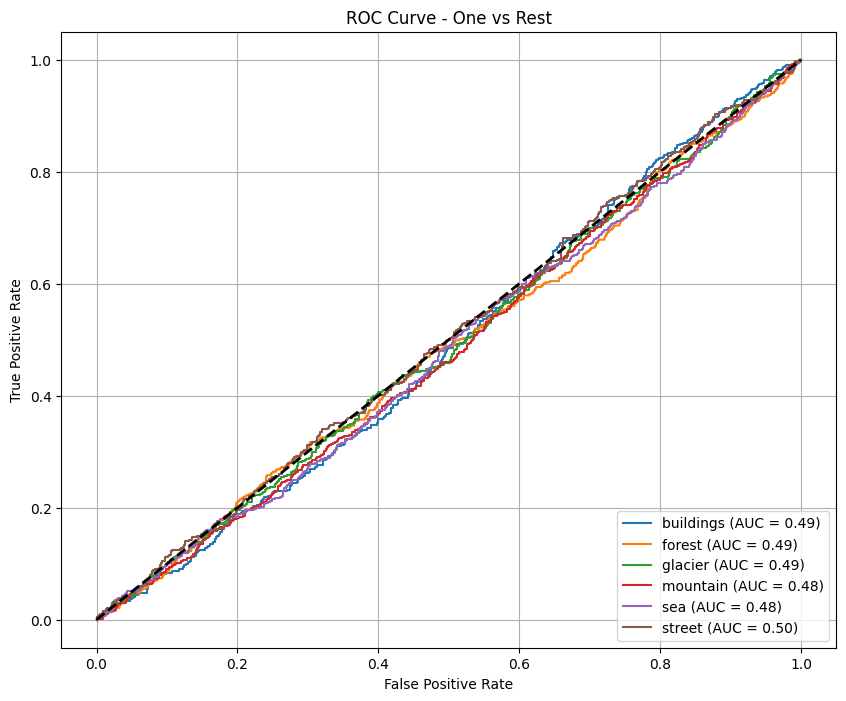

Z-Scores Sample: [-0.5469055  -0.5793074  -0.54854053 -0.5832167  -0.3672934 ]
T-test between 'forest' and 'mountain':
T-statistic = 1.6021, P-value = 0.1095


In [3]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_curve, auc
from scipy.stats import ttest_ind, zscore

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.preprocessing import label_binarize

# Paths
trainpath = '/kaggle/input/intel-image-classification/seg_train/seg_train'
testpath = '/kaggle/input/intel-image-classification/seg_test/seg_test'
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
SEED = 123

# Load train and validation subsets from train folder
train_ds = tf.keras.utils.image_dataset_from_directory(
    trainpath,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    trainpath,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

class_names = train_ds.class_names
num_classes = len(class_names)

# Normalize
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Build CNN
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train model
history = model.fit(train_ds, validation_data=val_ds, epochs=3)

# Get predictions
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# ROC Curve (One-vs-Rest)
y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
y_score = []

for images, _ in val_ds:
    preds = model.predict(images)
    y_score.extend(preds)

y_score = np.array(y_score)

# Plot ROC for each class
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - One vs Rest")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Z-test and T-test between two example classes
# We'll compare 'forest' and 'mountain' class confidences

forest_idx = class_names.index('forest')
mountain_idx = class_names.index('mountain')

forest_confidences = [score[forest_idx] for i, score in enumerate(y_score) if y_true[i] == forest_idx]
mountain_confidences = [score[mountain_idx] for i, score in enumerate(y_score) if y_true[i] == mountain_idx]

# Z-Test
z_scores = zscore(forest_confidences + mountain_confidences)
print(f"Z-Scores Sample: {z_scores[:5]}")

# T-Test
t_stat, p_val = ttest_ind(forest_confidences, mountain_confidences, equal_var=False)
print(f"T-test between 'forest' and 'mountain':\nT-statistic = {t_stat:.4f}, P-value = {p_val:.4f}")
